## Step 1: Put all libraries and packages at top

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Built-in imports

In [3]:
# built-in imports
import os
import sys
import time
import random

### Standard imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# working with images
import cv2
import imageio as iio

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F

# torchvision
import torchvision
import torchvision.transforms as transforms

# torchsummary
import torchsummary

# interactive progress bar
from tqdm import notebook

from IPython.display import clear_output

In [5]:
!pip install ipdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.7 MB/s eta 0:00:00


### Custom imports

In [6]:
sys.path.insert(0, '/content/drive/MyDrive/BBIoULoss_Updated_V5/kvasir-seg-main')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss
#from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

# transforms
from utils.transforms import SIZE, resize_transform, train_transforms, test_transforms

sys.path.insert(0, '/content/drive/MyDrive/BBIoULoss_Updated_V5/kvasir-seg-main/notebooks')

In [7]:
sys.path.insert(0, '..')

# models
from models.unet import UNet, UNet_attention

sys.path.insert(0, './notebooks')

## Step 2: Fix a seed for reproducibility, and choose the DEVICE

In [8]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda


## Step 3: Evaluate validation performance (quantitative, full sized images)

### Load model

In [10]:
%ls /content/drive/MyDrive/BBIoULoss_Updated_V5/kvasir-seg-main/checkpoints

README.md                            UNet_BiouLoss_baseline.pth
UNet_BBIoULoss_baseline.pth          UNet_IoUBCELoss_baseline.pth
UNet_BCEWithLogitsLoss_baseline.pth


In [17]:
model_name = 'UNet_BCEWithLogitsLoss_baseline'


# instansiate the model
if model_name == 'UNet_IoULoss_attention':
    model = UNet_attention(channel_in=3, channel_out=1)
else:
    model = UNet(channel_in=1, channel_out=1) # Changed channel_in back to 1

 # load model to DEVICE
model = model.to(DEVICE)

# load best weights and put into the evaluation mode
model.load_state_dict(torch.load(f'/content/drive/MyDrive/BBIoULoss_Updated_V5/kvasir-seg-main/checkpoints/{model_name}.pth')['net'])

model.eval() # Set the model to evaluation mode

UNet(
  (initial): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down0): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down1): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, tr

### Print info and Plot learning curves:

In [18]:
history = torch.load(f'/content/drive/MyDrive/BBIoULoss_Updated_V5/kvasir-seg-main/checkpoints/{model_name}.pth')

best_epoch = history['epoch']
best_iou = history['iou'].item()

print('Best epoch:', best_epoch)
print(f'Validation IoU:', best_iou)

Best epoch: 39
Validation IoU: 0.7708279490470886


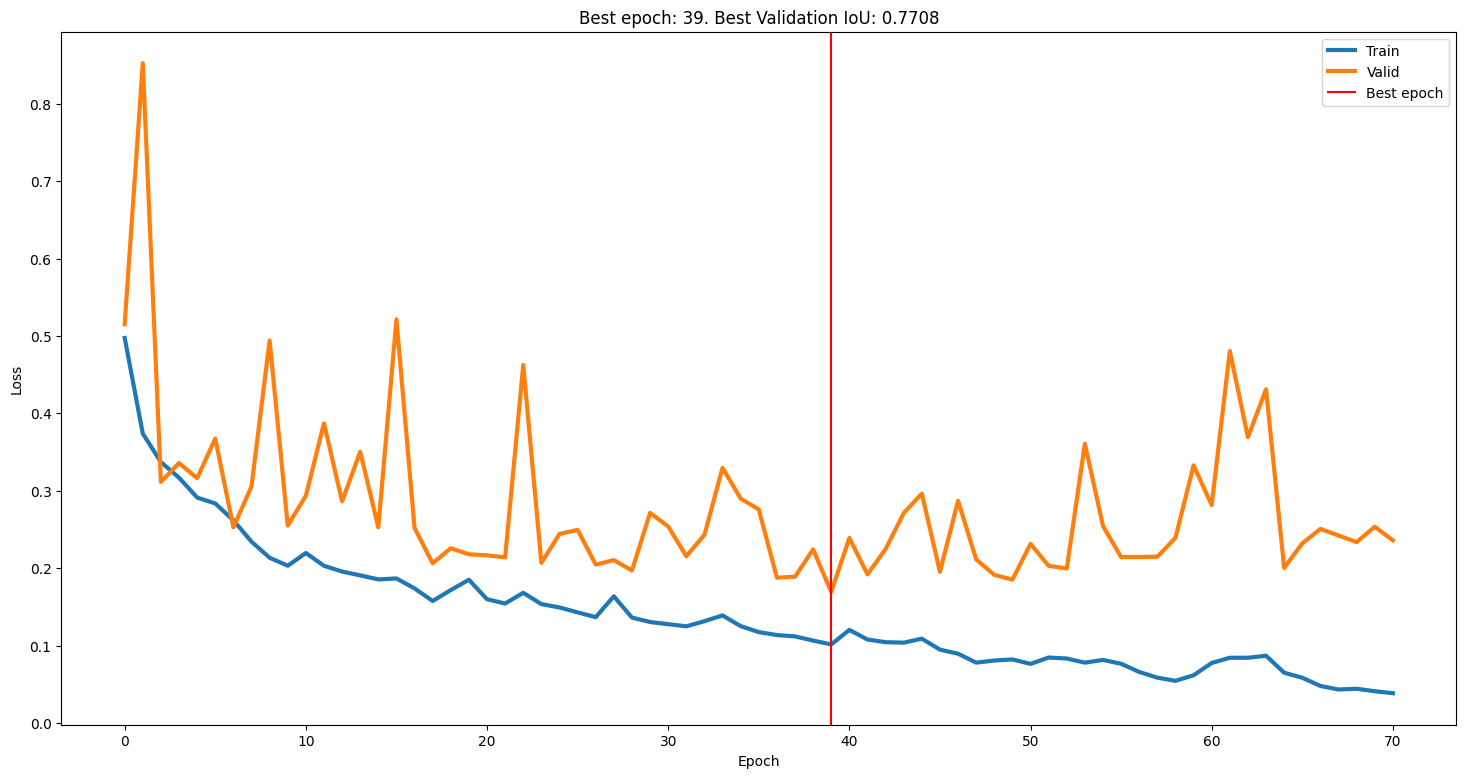

In [19]:
train_losses = history['train_losses']
val_losses = history['val_losses']

# plot
plt.figure(figsize=(18, 9))
plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train', linewidth=3)
plt.plot(np.arange(len(val_losses)), val_losses, label=f'Valid', linewidth=3)
plt.axvline(x=best_epoch, label='Best epoch', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Best epoch: {best_epoch}. Best Validation IoU: {best_iou:.4}')
plt.legend(loc='best')

# plt.savefig(f"../figures/learning_curves/{model_name}.svg")
plt.show()

### Produce predictions on Test Set

In [14]:
path_images = "/content/drive/MyDrive/BBIoULoss_Updated_V5/kvasir-seg-main/data/Skin_Cancer/Test/image"

In [15]:
%mkdir ../predictions_test

In [16]:
PRED_PATH = '../predictions_test'
os.makedirs(PRED_PATH, exist_ok=True)  # make sure folder exists
time_taken = []

model.eval()  # enter inference/evaluation mode
for name in notebook.tqdm(os.listdir(path_images)):
    path_img = os.path.join(path_images, name)
    img = iio.v3.imread(path_img)  # Read image

    # --- Ensure 3 channels (RGB) ---
    if img.ndim == 2:  # grayscale (H, W)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[-1] == 1:  # single-channel image (H, W, 1)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # record shape for resizing back later
    H, W = img.shape[:2]

    # Normalize and convert to FloatTensor
    img = img / 255.0
    img = torch.FloatTensor(np.transpose(img, [2, 0, 1])).unsqueeze(0)  # (1, 3, H, W)

    # resize for the model
    img = resize_transform(img)

    # put on GPU/CPU
    img = img.to(DEVICE)

    with torch.no_grad():
        start_time = time.time()
        pred = model(img)  # forward pass
        end_time = time.time() - start_time

    time_taken.append(end_time)

    # --- Resize back to original H, W ---
    resize_back = transforms.Resize((H, W), interpolation=transforms.InterpolationMode.NEAREST)
    pred = resize_back(pred)

    # put on cpu and process
    pred = pred.cpu().squeeze(0)       # (1, H, W) -> (H, W)
    pred = torch.sigmoid(pred)         # convert logits to probs
    pred = (pred > 0.5).squeeze(0)     # threshold -> binary mask
    pred = pred.numpy().astype(np.uint8) * 255  # to [0,255]

    # save prediction
    pred_path = os.path.join(PRED_PATH, name.replace('.jpg', '.png'))
    cv2.imwrite(pred_path, pred)

# Report FPS
mean_time_taken = np.mean(time_taken)
mean_fps = 1 / mean_time_taken
print("\nMean time per image: ", mean_time_taken)
print("Mean FPS: ", mean_fps)


  0%|          | 0/387 [00:00<?, ?it/s]

RuntimeError: Given groups=1, weight of size [64, 1, 3, 3], expected input[1, 3, 256, 256] to have 1 channels, but got 3 channels instead

## Step 5: Evaluate validation performance (visial, full sized images)

### Different cases

In [ ]:
#plt.figure(figsize=(15, 5))
total = 20

for i, name in enumerate(os.listdir(path_images)):
    print(name)
    plt.subplots(1, 2, sharex=True, sharey=True, figsize=(6, 2))

    plt.subplot(1,2,1)
    img = iio.v3.imread(f'{path_images}/{name}')
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.xlabel('Image')

    plt.subplot(1,2,2)
    pred = iio.v3.imread(f'{PRED_PATH}/{name}')
    plt.imshow(pred)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.xlabel('Prediction')


    plt.tight_layout(pad=0) # pad=0, w_pad=0, h_pad=0
    plt.show()

    print(80 * '-', '\n')

- fat: ckda9x11x000h3a5st1g20mrf.jpg
- medium: ckda1j0sy000n3a5stotfjqpc.jpg
- small: ckda0qhcw000e3a5s654bhalg.jpg
- very small: ckdaa07mq000o3a5s2y4iufmb.jpg

- flat: ckd8u18d7000c3b5suod5aqf2.jpg

In [ ]:
different_polyp_names = ['ckda9x11x000h3a5st1g20mrf.jpg', 'ckda1j0sy000n3a5stotfjqpc.jpg', 'ckda0qhcw000e3a5s654bhalg.jpg', 'ckdaa07mq000o3a5s2y4iufmb.jpg', 'ckd8u18d7000c3b5suod5aqf2.jpg']

In [ ]:
#plt.figure(figsize=(15, 5))
plt.subplots(2, 5, sharex=True, sharey=True, figsize=(11, 3.5))

for i, name in enumerate(different_polyp_names):

    plt.subplot(2,5,i+1)
    img = iio.v3.imread(f'{path_images}/{name}')
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Image')

    plt.subplot(2,5,i+6)
    pred = iio.v3.imread(f'{PRED_PATH}/{name}')
    plt.imshow(pred)
    plt.xticks([])
    plt.yticks([])
    if i == 0:
        plt.ylabel('Prediction')

    #print(metrics_df.loc[name].round(3))
    #print(80 * '-')

plt.tight_layout(pad=0, w_pad=0, h_pad=0) # pad=0, w_pad=0, h_pad=0
#plt.savefig('../figures/validation_examples/different_polyps_img_mask_pred.svg')
plt.show()